<a href="https://colab.research.google.com/github/danifeerrer/CaliHousing/blob/main/CaliforniaHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. DOWNLOADING THE DATA



In [36]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url="https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")

  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

# 2. TAKING A LOOK AT THE DATA STRUCTURE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


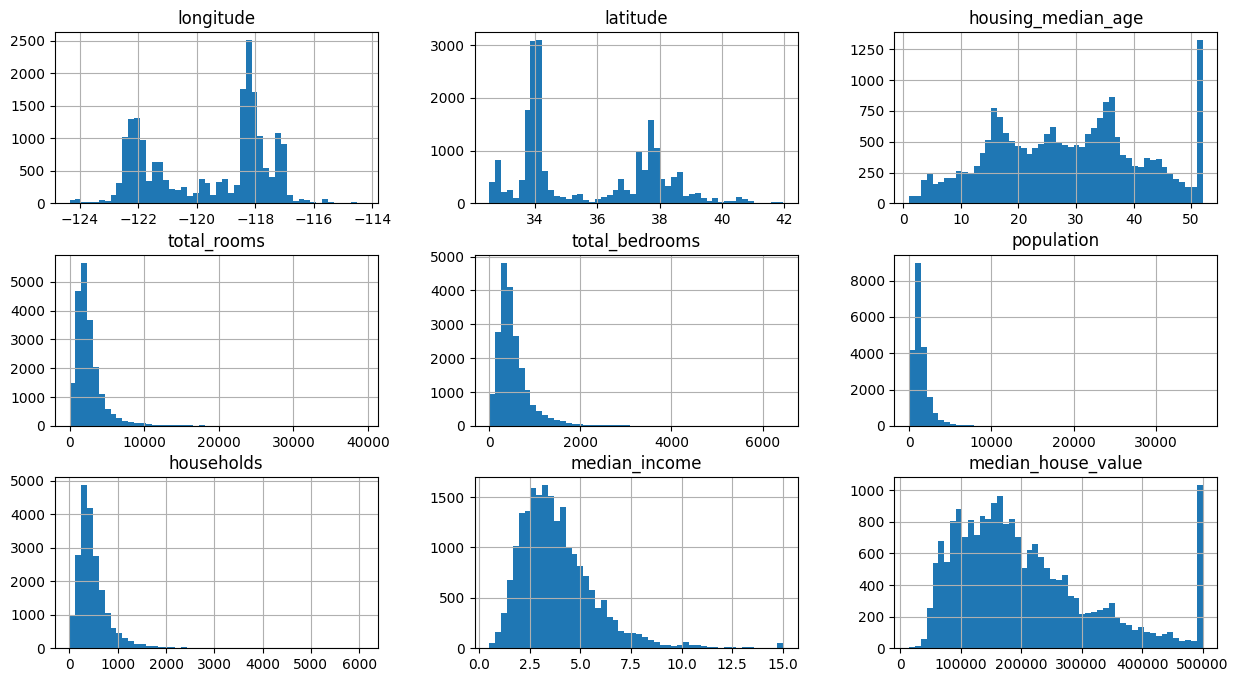

In [37]:
import matplotlib.pyplot as plt


housing.info()
housing.hist(bins=50, figsize=(15,8))
plt.show()


# 3. CREATING A TEST SET










**We've been told that the median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole data set.**




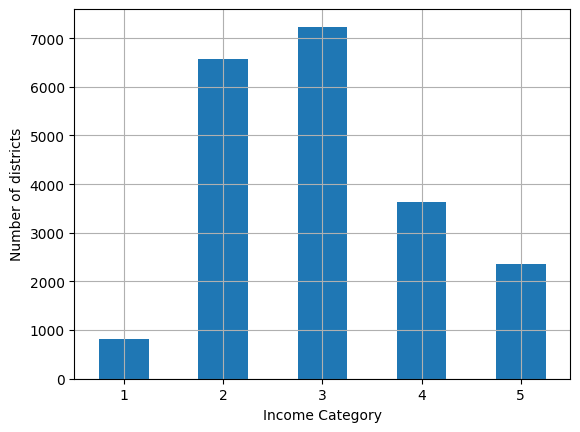

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])


housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()




**Now we divide the data into two sections, one for the train_set and the other for the test_set**

In [39]:
strat_train_set, strat_test_set = train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
strat_test_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 3905 to 3455
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           4128 non-null   float64 
 1   latitude            4128 non-null   float64 
 2   housing_median_age  4128 non-null   float64 
 3   total_rooms         4128 non-null   float64 
 4   total_bedrooms      4089 non-null   float64 
 5   population          4128 non-null   float64 
 6   households          4128 non-null   float64 
 7   median_income       4128 non-null   float64 
 8   median_house_value  4128 non-null   float64 
 9   ocean_proximity     4128 non-null   object  
 10  income_cat          4128 non-null   category
dtypes: category(1), float64(9), object(1)
memory usage: 359.0+ KB


# 4.VISUALIZING GEOGRAPHICAL DATA

**The figure that this code will display reflects California housing prices: red is expensive, blue is cheap, and larger circles indicate areas with a larger population**


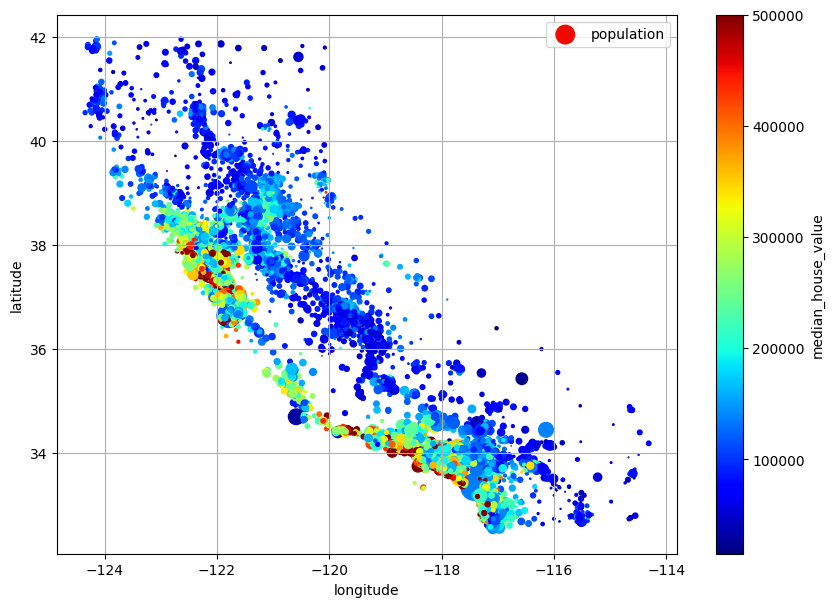

In [40]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

# 5. Prepare the data for machine learning algorithms

Separate the predictors and the labels, since you don't necessarily want to apply the same transformations to the predictors and the target values

In [41]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

**1. Clean the Data**



There are some missing values in the dataset, most machine learning algorithms cannot work with missing features, so we'll set the missing values to some value, in this case, the median.

We'll be using a handy Scikit-learn class: SimpleImputer. The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation test, the test set, and any new data fed to the model.

In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


Since the median can only be computed on numerical attributes, you then need to create a copy of the data with only numerical attributes.

In [43]:
housing_num=housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)




SimpleImputer(strategy='median')

Now, we can use this trained imputer to transform the training set by replacing missing values with the learned medians

In [44]:
X = imputer.transform(housing_num)


Missing values can also be replaced with the mean value (strategy="mean"), or with the most frequent value (strategy="most_frequent"), or with a constant value (strategy="constant", fill_value=...). The last two strategies support non numerical data.

Scikit-Learn transformers output Numpy arrays even when they are fed Pandas DataFrames as input. So, the output of *imputer.transform(housing_num)* is a NumPy array: X has neither column names nor index. Luckily, it's not hard to wrap X in a DataFrame and recover the column names and index from housing_num

In [45]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)


**2.Handling Text and Categorical Attributes**

The ocean_promixity column is a category attribute. Most machine learning algorithms prefer to work with numbers, so let's convert these categories from text to numbers

In [46]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases, but it is obviously not the case for the ocean_proximity column.

In [47]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()
print(cat_encoder.feature_names_in_)
print(cat_encoder.get_feature_names_out())


['ocean_proximity']
['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']


**3. Feature Scaling and Transformation**

The following code shows how to scale the labels using a StandardScaler, then train a simple linear regression models on the resulting scaled labels and use it to make predictions on some new data, which we transform back to the original scale using the trained scaler's inverse_transfrom method().

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()

scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:1]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
print(scaled_predictions)
print(predictions)

[[-0.64466228]]
[[131997.15275877]]


This works fine, but a simpler option is to use a TransformedTargetRegressor. We just need to construct it, giving it the regression model and the label transformer, then fit it on the training set, using the original unscaled labels. It will automatically scaled labels, just like we did previously.

In [49]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
print(predictions)

[131997.15275877]


**4. Custom Transformers**




It's often a good idea to transform features with heavy-tailed distributions by replacing them with their logarithm (assuming the feature is positive and the tail is on the right)


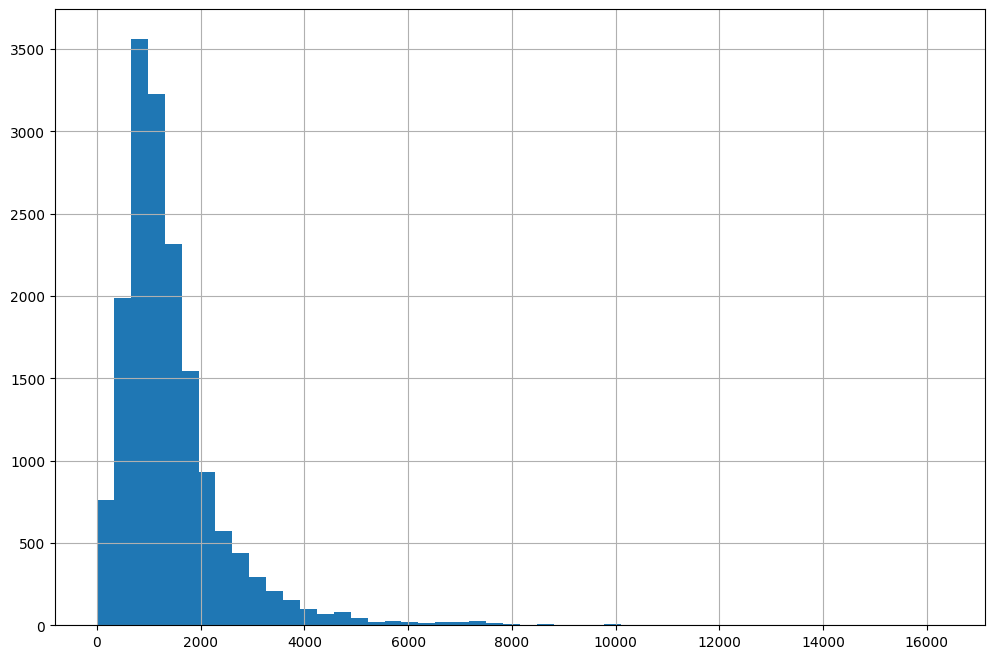

In [50]:
housing["population"].hist(bins=50, figsize=(12,8))
plt.show()

Let's create a log-transformer and apply it to the population feature


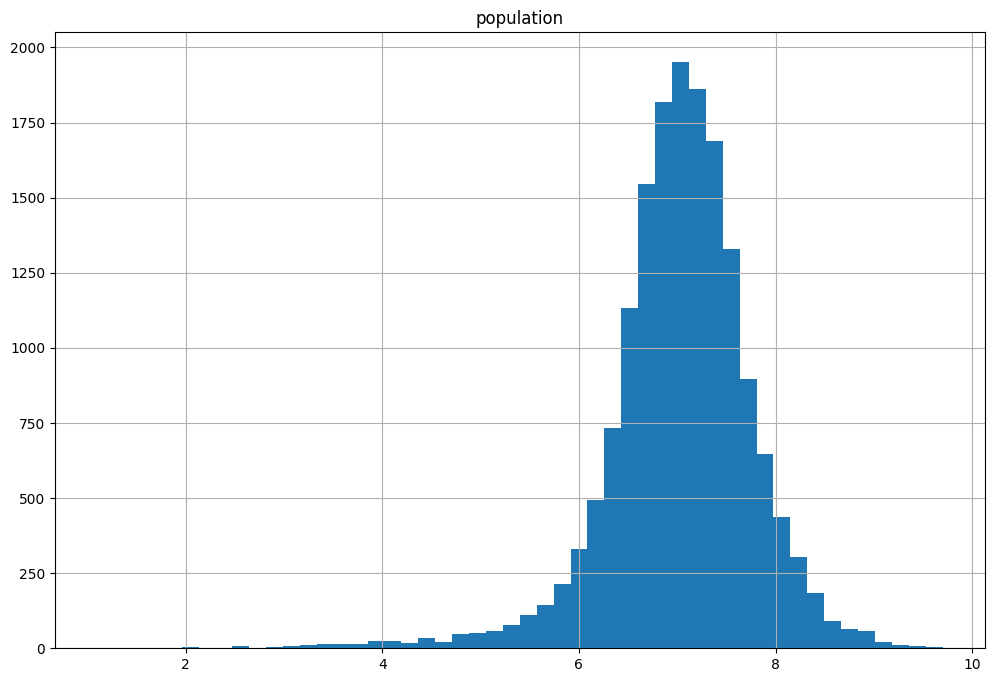

In [51]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

log_pop.hist(bins=50, figsize=(12,8))
plt.show()


This transformation can be useful in scenarios where you want to capture the similarity or distance between data points based on the RBF kernel. It can be applied to create features that reflect the similarity of each data point to a specific reference point (in this case, 35 years of age). The resulting transformed data can then be used as input for further analysis or modeling tasks.

In [52]:
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
print(age_simil_35)


[[2.81118530e-13]
 [8.20849986e-02]
 [6.70320046e-01]
 ...
 [9.55316054e-22]
 [6.70320046e-01]
 [3.03539138e-04]]


The following code demonstrates the custom transformer that uses a Kmeans clusterer in the fit() method to identify the main clusters in the training data, and then uses rbf_kernel() in the transform method to measure how similar each sample is to each cluster center

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[0.7  0.   1.   0.   0.   0.   0.06 0.   0.09 0.  ]
 [0.45 0.   0.91 0.   0.   0.   0.02 0.   0.2  0.  ]
 [0.93 0.   0.78 0.   0.   0.   0.23 0.   0.02 0.  ]]
['Cluster 0 similarity', 'Cluster 1 similarity', 'Cluster 2 similarity', 'Cluster 3 similarity', 'Cluster 4 similarity', 'Cluster 5 similarity', 'Cluster 6 similarity', 'Cluster 7 similarity', 'Cluster 8 similarity', 'Cluster 9 similarity']


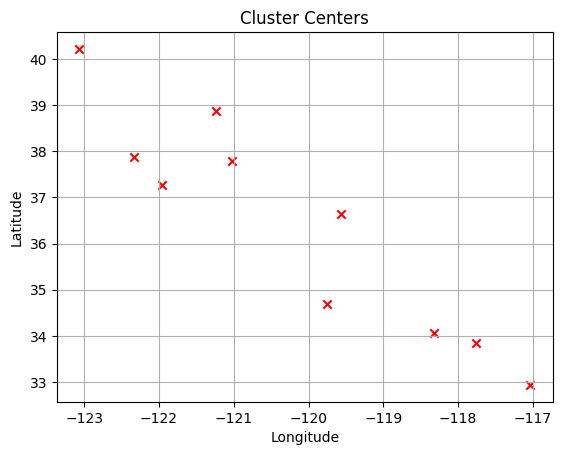

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=42)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)
print(similarities[50:53].round(2))
print(cluster_simil.get_feature_names_out())

cluster_centers = cluster_simil.kmeans_.cluster_centers_

# Create a scatter plot of the cluster centers
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], c='red', marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers')
plt.grid(True)
plt.show()

5. **Transformation Pipeline**



1.   Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don't expect missing values. In categorical features, missing values will be replaced by the most frequent category
2.   The categorical feature will be one hot encoded, as most ML algorithms only accept numerical inputs
3.   A few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, and people_per_house. Hopefully, these will better correlate with the median house value, and thereby help the ML models
4.   A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude
5.   Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions
6.   All numerical features will be standarized, as most ML algorithms prefer when all features have roughly the same scale





In [55]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
                                   ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
                                   ("people_per_house", ratio_pipeline(), ["population", "households"]),
                                   ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                                                          "households", "median_income"]),
                                   ("geo", cluster_simil, ["latitude", "longitude"]),
                                   ("cat", cat_pipeline, make_column_selector(dtype_include=object))],
                                  remainder=default_num_pipeline)


housing.drop('income_cat', axis=1, inplace=True)
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = [{
    'preprocessing__geo__n_clusters': [5,8,10],
    'random_forest__max_features': [4,6,8]},
    {'preprocessing__geo__n_clusters': [10,15],
    'random_forest__max_features': [6,8,10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(housing, housing_labels)

In [61]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3,high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs
                                , n_iter=10, cv=3,
                                scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fdef0bf0340>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fdef01b11e0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [73]:
print(rnd_search.best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fdf030...
                                                  ClusterSimilarity(n_clusters=45,
                                                                

In [72]:
from sklearn.metrics import mean_squared_error

final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)


41424.40026462184
